In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
import ctypes

import pprint
import h5py
import wtowers.wtowers as wtowers

In [29]:
plt.rcParams['figure.figsize'] = [12, 8]
h5name = "/home/vlad/software/SKA/Radio-Gridders/data/crocodile_data/vis/vlaa_theta0.1.h5"
h5name_wkern = "/home/vlad/software/SKA/Radio-Gridders/data/crocodile_data/kernels/vla_w20_static_size15.h5"

npixdirty   = 3000
degsize     = 2.0
nthreads    = 4 
epsilon     = 6e-6
DEG2RAD     = np.pi/180.

In [30]:
with h5py.File(h5name, 'r') as f:
    uvw = f['vis']['uvw'][:]
    ms = f['vis']['vis'][:]
    freq = f['vis']['frequency'][:]
    for key in f['vis'].keys():
        print(key)

antenna1
antenna2
frequency
time
uvw
vis


In [31]:
print(uvw.shape)
print(ms.shape)
print(freq.shape)

(702000, 3)
(702000, 100, 1)
(100,)


In [32]:
min_len = -1.79768e+308
max_len = 1.79769e+308
vis = wtowers.VIS_DATA()

In [33]:
wtowers.init_dtype_cpx_func()
status = wtowers.load_vis_func(h5name,vis, min_len, max_len)

In [34]:
vis.bl_count

702000

In [35]:
theta = 0.1
uvlambda = 18500
grid_size = int(theta*uvlambda)
uvgrid = np.zeros(grid_size*grid_size, dtype=np.complex128)
#flops = wtowers.grid_simple_func(uvgrid, grid_size, theta, vis)

In [36]:
# Check the uvlambda w.r.t. the actual uv values
status = wtowers.check_grid_size_func(vis,uvlambda)
if status != 0:
    class StopExecution(Exception):
        def _render_traceback_(self):
            pass
    raise StopExecution

In [37]:
wkern = wtowers.W_KERNEL_DATA()
status = wtowers.load_wkern_func(h5name_wkern, theta, wkern)
print("load_wkern status:", status)

load_wkern status: 0


In [38]:
subgrid_size = 100
margin=20
winc=20

237591.64999771785 -61128.142476202614


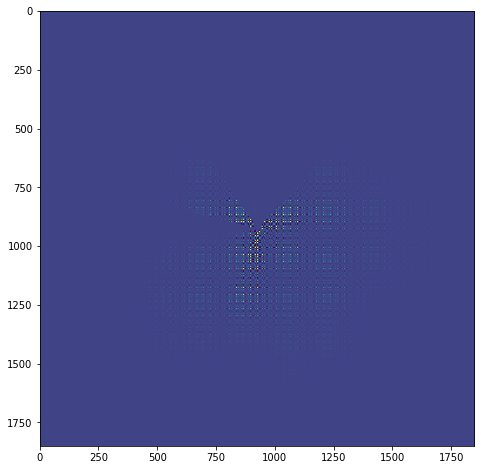

In [39]:
#wtowers.weight_func(grid_size, theta, vis)
#flops = wtowers.grid_simple_func(uvgrid, grid_size, theta, vis)
#flops = wtowers.grid_wtowers_func(uvgrid, grid_size, theta, vis, wkern, subgrid_size, margin, winc)
flops = wtowers.grid_wprojection_func(uvgrid, grid_size, theta, vis, wkern)

uvmax_real = np.amax(np.real(uvgrid))
uvmin_real = np.amin(np.real(uvgrid))
print(uvmax_real, uvmin_real)
plt.imshow(np.real(uvgrid.reshape(grid_size,grid_size)), vmin = uvmin_real/20., vmax = uvmax_real/20.)
#plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

In [40]:
fname = './pregrid.out'
if os.path.isfile(fname):
    pregrid = np.fromfile(fname, dtype='double')
    gsize = int(np.sqrt(len(pregrid)))
    pregrid = pregrid.reshape((gsize,gsize))
    pmax = np.amax(pregrid)
    pmin = np.amin(pregrid)
    print(pmin, pmax)
    plt.imshow(pregrid,vmin = pmin/20., vmax = pmax/20.)
    plt.show()

In [41]:
wtowers.make_hermitian_func(uvgrid, grid_size)

In [42]:
np.amax(uvgrid)

(238528.65506338567+1480.3765880824587j)

In [43]:
uvgrid = uvgrid.reshape((grid_size,grid_size))
img = np.fft.fft2(np.fft.fftshift(uvgrid))
img = np.fft.fftshift(img)

-6312118.340621065 141386423.88841897


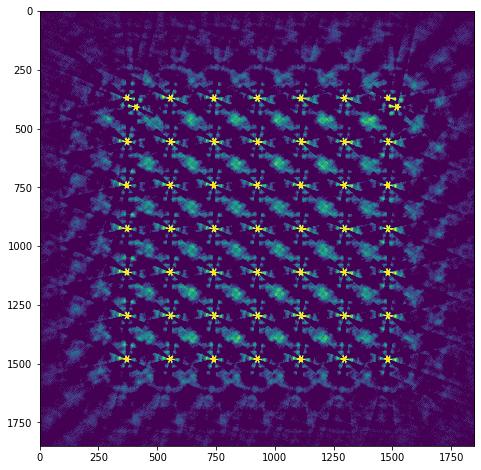

In [44]:
dirty = np.real(img)
dirtymax = np.amax(dirty)
dirtymin = np.amin(dirty)
print(dirtymin,dirtymax)
plt.imshow(dirty, vmin=0, vmax = dirtymax/50.)
#plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

In [45]:
fname = './image.out'
if os.path.isfile(fname):
    xout = np.fromfile(fname, dtype='double')
    gsize = int(np.sqrt(len(xout)))
    xout = xout.reshape((gsize,gsize))
    xoutmax = np.amax(xout)
    xoutmin = np.amin(xout)
    print(xoutmin, xoutmax)
    plt.imshow(xout,vmin = 0, vmax = xoutmax/50.)
    plt.show()

In [46]:
# Create de-gridded visibility structure with the same times and uvw
vis_degrid = wtowers.VIS_DATA()
wtowers.copy_vis_data_func(vis_degrid, vis,1)
#wtowers.fill_vis_data_func(vis_degrid,vis.antenna_count,vis.bl_count, vis.bl[0].time_count, 1)

0

In [47]:
print(vis.antenna_count, vis.bl_count,vis.bl[0].time_count)
print(vis_degrid.antenna_count, vis_degrid.bl_count,vis_degrid.bl[0].time_count )
assert(vis_degrid.bl_count == vis.bl_count)

26 702000 1
26 702000 1


In [48]:
# Find the mean frequency
#freq_degrid = np.mean(np.ctypeslib.as_array(vis.bl[0].freq, shape=(vis.bl[0].freq_count,)))
#print(vis.bl[vis.bl_count-1].time[0], vis.bl[vis.bl_count-1].freq_count, vis.bl[vis.bl_count-1].freq[0])

In [49]:
# Replace all the freqquency counts with 1, and freq[0] with freq_degrid
#for i in range(vis_degrid.bl_count):
#	vis_degrid.bl[i].antenna1 = vis.bl[i].antenna1
#	vis_degrid.bl[i].antenna2 = vis.bl[i].antenna2
#	
#	vis_degrid.bl[i].freq_count = 1
#	vis_degrid.bl[i].freq[0] = freq_degrid
#	vis_degrid.bl[i].uvw = vis.bl[i].uvw
#	vis_degrid.bl[i].time = vis.bl[i].time


In [50]:
# Degrid at freq_degrid which is a mean frequency
#print("De-gridding at ",freq_degrid, "Hz")
#wtowers.degrid_simple_func(vis_degrid,uvgrid.reshape((grid_size*grid_size)),grid_size, theta)
wtowers.degrid_wprojection_func(vis_degrid,uvgrid.reshape((grid_size*grid_size)),grid_size, theta, wkern)

126360000000

In [51]:
print("Gridding again...")
uvgrid1 = np.zeros(grid_size*grid_size, dtype=np.complex128)
#wtowers.weight_func(grid_size, theta, vis_degrid)
#flops = wtowers.grid_simple_func(uvgrid1, grid_size, theta, vis_degrid)
flops = wtowers.grid_wprojection_func(uvgrid1, grid_size, theta, vis_degrid, wkern)

Gridding again...


In [52]:
# Fill a hermitian conjugated part of the uv_grid plane
wtowers.make_hermitian_func(uvgrid1, grid_size)

In [53]:
uvgrid1 = uvgrid1.reshape((grid_size,grid_size))

Dirty min and max:  -10941838335.765759 58558937095.116615


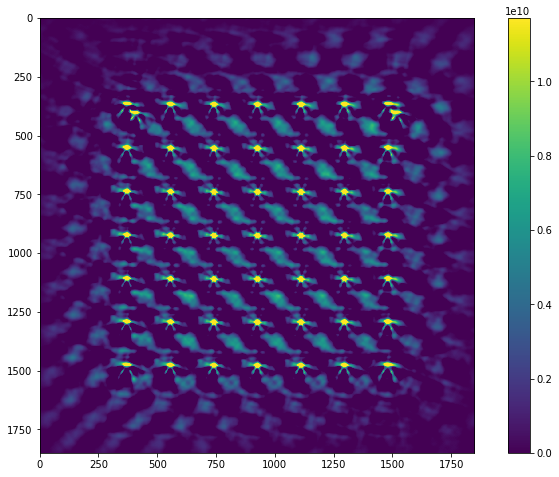

In [56]:
# Create a dirty image and show 
img = np.fft.fft2(np.fft.fftshift(uvgrid1))
img = np.fft.fftshift(img)
dirty = np.real(img)
dirtymax = np.amax(dirty)
dirtymin = np.amin(dirty)
print("Dirty min and max: ", dirtymin,dirtymax)
plt.clf()
plt.imshow(dirty, vmin=0, vmax = dirtymax/5.)
plt.colorbar()
#plt.savefig('Simple_grid-degrid-grid_dirty.png')
plt.show()